# Домашнее задание 3. Классификация текстов по жанрам

В этом домашнем задании мы рассмотрим задачу классификации на  несколько классов. Будем классифицировать тексты песен по музыкальным жанрам ( рок, рэп, панк и т.д.). Рассмотрим два варианта составления признакового пространства: обычное векторное представление текстов и расширение векторного пространства с использованием внешнего словаря эмоционально окрашенных слов.

### Задание 1
Считаем тексты из файла, удалим в файле пустые строки.

In [1]:
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk
from nltk import FreqDist

%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("songs.csv")

In [3]:
print (data.shape)
data.head()

(7325, 5)


,artist,album,song,lyrics,genre
0,Eminem,The Marshall Mathers LP 2 (2013) Eminem,bad guy,[Part 1: Produced by S1 and M-Phazes][Verse 1]...,rap
1,Eminem,The Marshall Mathers LP 2 (2013) Eminem,parking lot (skit),[Teller] Don't kill me! [Eminem] Hurry the fu...,rap
2,Eminem,The Marshall Mathers LP 2 (2013) Eminem,rhyme or reason,[Intro] (What's your name?) Marshall (Who's yo...,rap
3,Eminem,The Marshall Mathers LP 2 (2013) Eminem,so much better,[Intro] You fucking groupie Pick up the goddam...,rap
4,Eminem,The Marshall Mathers LP 2 (2013) Eminem,survival,[Hook: Liz Rodrigues] This is survival of the ...,rap


In [4]:
data=data[~data['lyrics'].isnull()]
print (data.shape)

(7255, 5)


Приведем словак нижнему регистру, удалим цифры, знаки препинания, разобьем текс песен на отдельные слова 

In [5]:
import re
regex = re.compile("[A-Za-z]+") 
data['lyrics']=data['lyrics'].apply(lambda x: regex.findall(x.lower()))

Удалим стоп-слова из текстов песен. Для стемминга текстов песен используем стеммер Портера

In [6]:
%%time
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
data['lyrics']=data['lyrics'].apply(lambda text: [token for token in text if not token in stopwords])   

Wall time: 5.89 s


In [7]:
# http://www.programcreek.com/python/example/52655/nltk.PorterStemmer
def stem_words_array(words_array):
    stemmer = nltk.PorterStemmer()
    stemmed_words_array = []
    for word in words_array:
        try:
            stem = stemmer.stem(word)
            stemmed_words_array.append(stem)
        except Exception:
            pass

    return stemmed_words_array

In [8]:
%%time
data['lyrics']=data['lyrics'].apply(lambda x: stem_words_array(x))

Wall time: 48.7 s


In [9]:
import pickle
data.to_pickle('data_PorterStemmer.pkl') 

Посчитаем описательные статистики: среднюю длину песен каждого жанра, самые частые слова (без стоп-слов) в каждом
жанре

In [10]:
from nltk import FreqDist
from collections import OrderedDict

In [11]:
agg_genre = pd.DataFrame(data.groupby(by='genre').agg({'lyrics' : lambda x: np.sum(x),
                                                       'genre' : 'count'}))
agg_genre.columns=['text','count']

In [12]:
# посчитаем среднюю длину  в словах песен каждого жанра
agg_genre['avg len text']=agg_genre['text'].apply(lambda x: len(x))/agg_genre['count']
# найдем самые частые слова и расположим их по порядку убывания с помошью OrderedDict
agg_genre['freq words']=agg_genre['text'].apply(lambda x: \
                    OrderedDict(sorted(FreqDist(x).items(),key=lambda x: x[1],reverse=True)))

In [13]:
agg_genre

,text,count,avg len text,freq words
genre,,,,
classic_rock,"[vers, hear, babi, come, track, batch, babi, c...",1275,99.492549,"{'love': 1910, 'vers': 1815, 'know': 1657, 'ch..."
deathcore,"[intro, crucifi, nail, hand, wooden, cross, no...",1308,92.403670,"{'fuck': 1471, 'never': 1059, 'one': 1038, 'li..."
grunge,"[vers, load, gun, bring, friend, fun, lose, pr...",784,88.808673,"{'choru': 1345, 'vers': 1050, 'like': 756, 'ye..."
pop,"[vers, yeah, breakin, feel, like, know, want, ...",1188,175.602694,"{'oh': 4812, 'love': 4303, 'choru': 3901, 'kno..."
pop_punk,"[prelud, mark, hoppu, matt, skiba, cynic, feel...",1314,124.076865,"{'choru': 2637, 'go': 2306, 'know': 2256, 'oh'..."
rap,"[part, produc, phaze, vers, like, dirt, dig, o...",1386,325.898990,"{'nigga': 7845, 'like': 6640, 'get': 5832, 'go..."


In [14]:
most_freq=pd.DataFrame()
i=0
for text in agg_genre['freq words']:
    most_freq_= pd.Series(text).reset_index()   
    most_freq_.columns = [agg_genre.index[i],'count']
    most_freq = pd.concat([most_freq, most_freq_], axis=1)
    i+=1

Топ-10 слов для каждого жанра песен

In [15]:
most_freq[:10]

,classic_rock,count,deathcore,count,grunge,count,pop,count,pop_punk,count,rap,count
0,love,1910.0,fuck,1471.0,choru,1345.0,oh,4812.0,choru,2637.0,nigga,7845
1,vers,1815.0,never,1059.0,vers,1050.0,love,4303.0,go,2306.0,like,6640
2,know,1657.0,one,1038.0,like,756.0,choru,3901.0,know,2256.0,get,5832
3,choru,1630.0,life,937.0,yeah,754.0,know,3285.0,oh,2205.0,got,4734
4,oh,1615.0,see,880.0,know,725.0,like,3181.0,like,1853.0,know,4375
5,got,1387.0,time,845.0,time,702.0,babi,2752.0,get,1751.0,shit,3814
6,go,1206.0,let,809.0,come,679.0,vers,2488.0,vers,1724.0,fuck,3497
7,babi,1120.0,know,803.0,one,642.0,get,2297.0,want,1712.0,hook,3188
8,yeah,1087.0,world,752.0,go,632.0,yeah,2264.0,time,1644.0,bitch,2985
9,like,1074.0,take,751.0,want,629.0,got,2245.0,never,1542.0,go,2758


Средняя длина в словах песен каждого жанра

In [16]:
del agg_genre['text'],agg_genre['freq words']
agg_genre

,count,avg len text
genre,,
classic_rock,1275,99.492549
deathcore,1308,92.403670
grunge,784,88.808673
pop,1188,175.602694
pop_punk,1314,124.076865
rap,1386,325.898990


In [17]:
del agg_genre,most_freq # освободим память

Распеределение текстов песен по жанрам

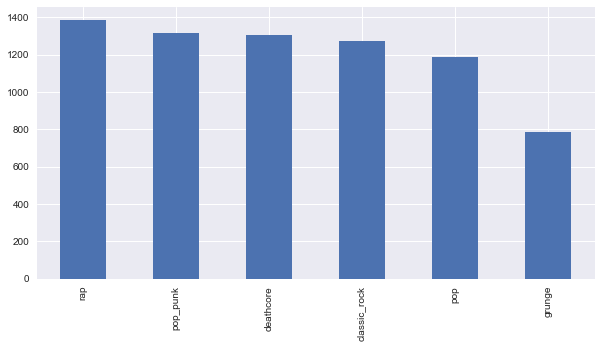

In [18]:
plt.figure(figsize(10,5));
data['genre'].value_counts().plot(kind="bar", rot=90);

Распеределение текстов песен по артистам

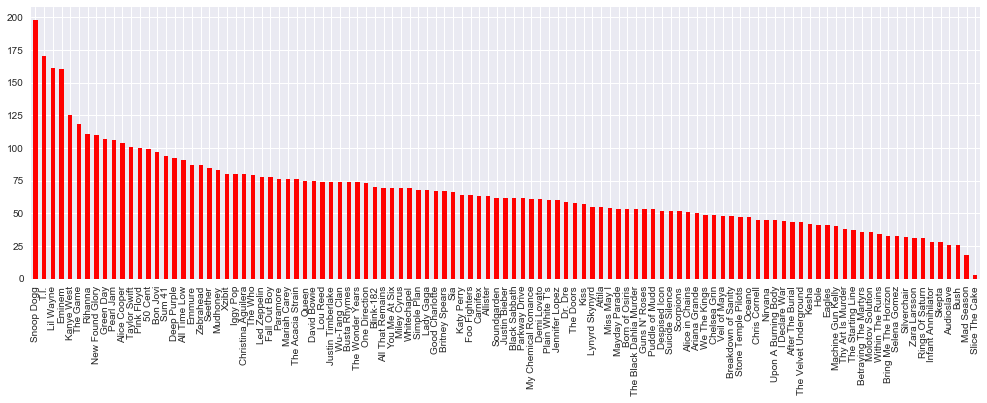

In [19]:
plt.figure(figsize(17,5));
data['artist'].value_counts().plot(kind="bar", rot=90,color='r');

Составьте сбалансированные тестовые и обучающие множества

In [20]:
data['lyrics']=data['lyrics'].apply(lambda x: ' '.join(x))
data=data[['lyrics','genre']]

In [21]:
data.head()

,lyrics,genre
0,part produc phaze vers like dirt dig old hurt ...,rap
1,teller kill eminem hurri fuck shoot teller tha...,rap
2,intro name marshal daddi one vers mother repro...,rap
3,intro fuck groupi pick goddamn phone vers bitc...,rap
4,hook liz rodrigu surviv fittest die winner tak...,rap


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['lyrics'], data['genre'], test_size=0.33, random_state=7)

In [23]:
X_train[:5]

2436                                           instrument
4987    intro hey excus vers hi name bob work job make...
5392    vers new boy stranger town good time gonna sho...
584     intro made far upstair let special marley shoo...
5670    vers lost ten point right place exactli wrong ...
Name: lyrics, dtype: object

In [24]:
 y_train.value_counts()/len(y_train)

rap             0.190947
deathcore       0.182510
pop_punk        0.177984
classic_rock    0.172634
pop             0.166667
grunge          0.109259
Name: genre, dtype: float64

In [25]:
y_test.value_counts()/len(y_test)

rap             0.191232
pop_punk        0.187474
classic_rock    0.182046
deathcore       0.175783
pop             0.157829
grunge          0.105637
Name: genre, dtype: float64

In [26]:
del data

### Задание 2

Будем классифицировать тексты песен по жанрам (один жанр один класс). На этом этапе используем обычное векторное представление текстов. Задайте pipeline для классификации текстов.

In [27]:
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import *  # CountVectorizer, TfidfVectorizer,TfidfTransforme

In [28]:
from sklearn.naive_bayes import MultinomialNB # Наивный Байесовский классификатор 
from sklearn.linear_model import SGDClassifier, LogisticRegression # Машины опорных векторов, Метод максимальной энтропии
from sklearn.ensemble import RandomForestClassifier #Случайный лес

In [29]:
# https://www.youtube.com/watch?v=U0LOSHY7U5Q
# https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/Document%20classification%20with%20word%20embeddings%20tutorial.ipynb
# RU_TextClassification-inCLass

Создадим фунции для анализа классификации - расчета метрик и отрисовки матрицы

In [30]:
#labels = list(clf.classes_)
labels=['classic_rock', 'deathcore', 'grunge', 'pop', 'pop_punk', 'rap']

In [31]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize(7,6));
    sns.heatmap(data=cm, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels, cmap=cmap)
    plt.title(title)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print("Precision macro: {0:6.2f}".format(precision_score(target, predictions, average='macro')))
    print("Precision micro: {0:6.2f}".format(precision_score(target, predictions, average='micro')))
    print("Recall         : {0:6.2f}".format(recall_score(target, predictions, average='macro')))
    print("F1-measure     : {0:6.2f}".format(f1_score(target, predictions, average='macro')))
    print("Accuracy       : {0:6.2f}".format(accuracy_score(target, predictions)))
    #print(classification_report(target, predictions))
    
    cm = confusion_matrix(target, predictions)    
    plot_confusion_matrix(cm, title) # вызов

In [33]:
def predict(classifier, X,y):
    predictions = classifier.predict(X)    
    evaluate_prediction(predictions,  y) # вызов

### Bag of words

Рассмотрим наивный Байесовский классификатор

In [123]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),])

clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Precision macro:   0.57
Precision micro:   0.63
Recall         :   0.58
F1-measure     :   0.54
Accuracy       :   0.63
Wall time: 563 ms


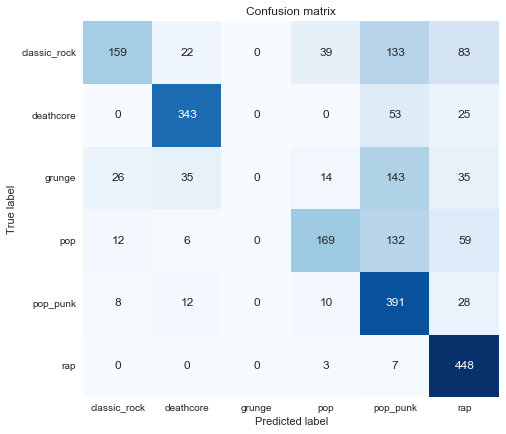

In [124]:
%%time
predict(clf, X_test,y_test)

Рассмотрим классификатор случайный лес 

In [125]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,1))),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),])

clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

Precision macro:   0.57
Precision micro:   0.60
Recall         :   0.57
F1-measure     :   0.57
Accuracy       :   0.60
Wall time: 578 ms


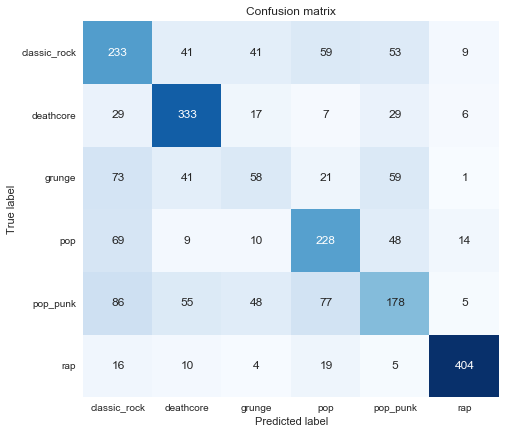

In [126]:
%%time
predict(clf, X_test,y_test)

Рассмотрим классификатор логистическая регрессия. 

Для того чтобы посмотреть наиболее значимые слова для каждого жанра песен реализуем без Pipeline

In [130]:
%%time
count_vectorizer = CountVectorizer(analyzer="word",preprocessor=None, max_features=3000) 
train_data = count_vectorizer.fit_transform(X_train)

logreg = LogisticRegression(n_jobs=-1, C=1e5)
logreg = logreg.fit(train_data, y_train)

Wall time: 8.53 s


Precision macro:   0.64
Precision micro:   0.66
Recall         :   0.64
F1-measure     :   0.64
Accuracy       :   0.66


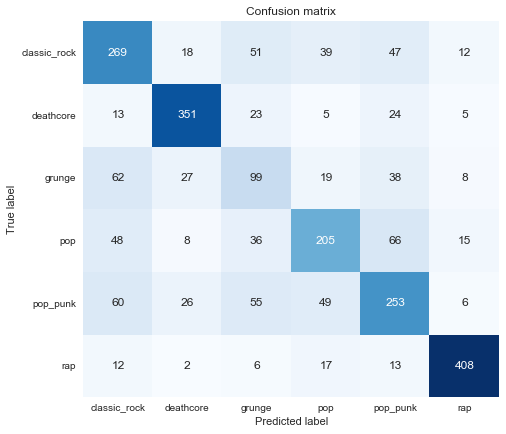

In [132]:
data_test = count_vectorizer.transform(X_test)
predict(logreg,data_test,y_test)

Посмотрим наиболее важные с точки зрения классификатора слова для жанра

In [223]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]

In [144]:
#labels=['classic_rock', 'deathcore', 'grunge', 'pop', 'pop_punk', 'rap']
genre_tag_id = 1
print(labels[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

deathcore


['trembl',
 'intro',
 'solo',
 'motherfuck',
 'whisper',
 'option',
 'paint',
 'price',
 'crush',
 'grave']

In [152]:
genre_tag_id = 5
print(labels[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

rap


['shawti',
 'ear',
 'eminem',
 'album',
 'shift',
 'flip',
 'enter',
 'art',
 'cock',
 'edit']

### Character N-grams

Рассмотрим в том же порядке - наивный Байесовский классификатор, случайный лес, логистическую регрессию.

In [133]:
%%time
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,5))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])

clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 5), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Precision macro:   0.68
Precision micro:   0.59
Recall         :   0.55
F1-measure     :   0.53
Accuracy       :   0.59
Wall time: 2.31 s


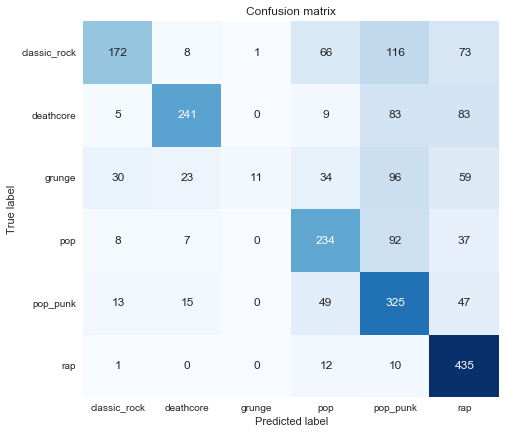

In [134]:
%%time
predict(clf, X_test,y_test)

In [137]:
%%time
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,5))),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

clf.fit(X_train, y_train)

Wall time: 41.4 s


Precision macro:   0.53
Precision micro:   0.53
Recall         :   0.50
F1-measure     :   0.49
Accuracy       :   0.53
Wall time: 2.83 s


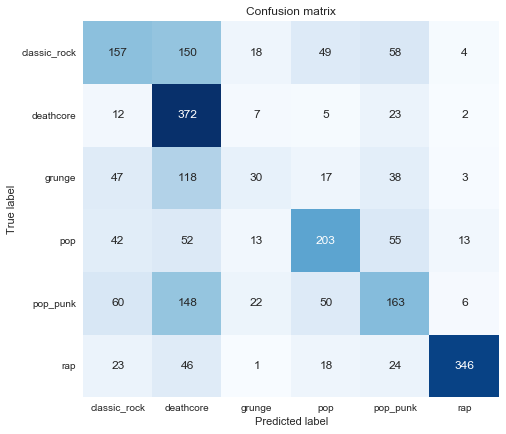

In [138]:
%%time
predict(clf, X_test,y_test)

In [165]:
%%time
count_vectorizer = CountVectorizer(analyzer="char",ngram_range=([2,5]),preprocessor=None, max_features=3000) 
train_data = count_vectorizer.fit_transform(X_train)

logreg = LogisticRegression(n_jobs=-1, C=1e5)
logreg = logreg.fit(train_data, y_train)

Wall time: 1min 27s


Precision macro:   0.62
Precision micro:   0.63
Recall         :   0.61
F1-measure     :   0.61
Accuracy       :   0.63
Wall time: 7.08 s


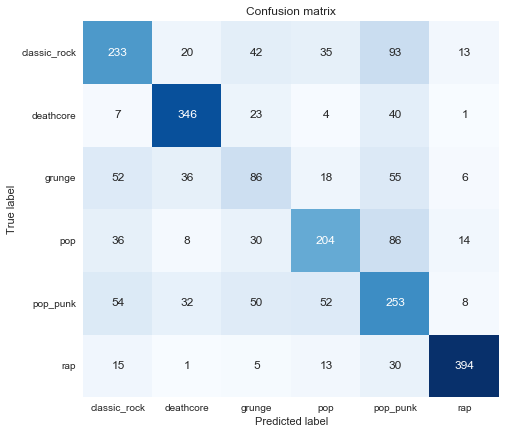

In [166]:
%%time
data_test = count_vectorizer.transform(X_test)
predict(logreg,data_test,y_test)

In [167]:
#labels=['classic_rock', 'deathcore', 'grunge', 'pop', 'pop_punk', 'rap']
genre_tag_id = 5
print(labels[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

rap


['bu', 'y s', ' ar', 'e y', 'ka', 'oop', ' vers', 'p ', 'e ye', 'ent']

### TF-IDF

In [170]:
%%time
clf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=2,preprocessor=None)),
    ('clf', MultinomialNB())])

clf.fit(X_train, y_train)

Wall time: 828 ms


Precision macro:   0.58
Precision micro:   0.65
Recall         :   0.60
F1-measure     :   0.57
Accuracy       :   0.65
Wall time: 547 ms


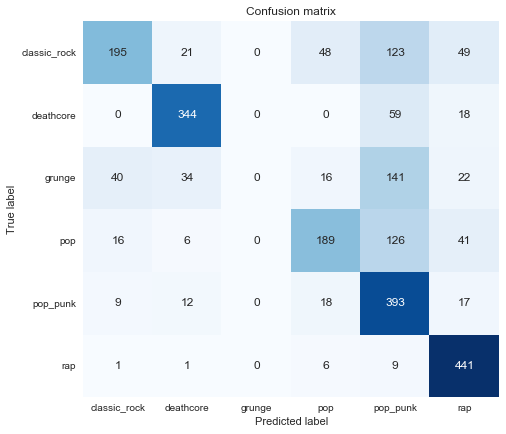

In [171]:
%%time
predict(clf, X_test,y_test)

In [168]:
%%time
clf = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=2,preprocessor=None)),
    ('clf', RandomForestClassifier())])

clf.fit(X_train, y_train)

Wall time: 1.93 s


Precision macro:   0.57
Precision micro:   0.60
Recall         :   0.57
F1-measure     :   0.56
Accuracy       :   0.60
Wall time: 561 ms


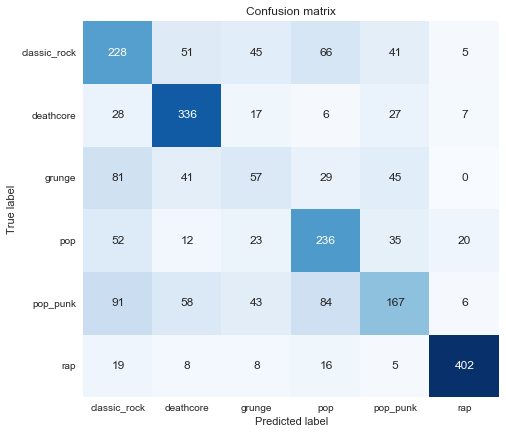

In [169]:
%%time
predict(clf, X_test,y_test)

In [172]:
%%time
count_vectorizer = TfidfVectorizer(min_df=2,preprocessor=None)
train_data = count_vectorizer.fit_transform(X_train)

logreg = LogisticRegression(n_jobs=-1, C=1e5)
logreg = logreg.fit(train_data, y_train)

Wall time: 3.22 s


Precision macro:   0.68
Precision micro:   0.69
Recall         :   0.67
F1-measure     :   0.67
Accuracy       :   0.69
Wall time: 641 ms


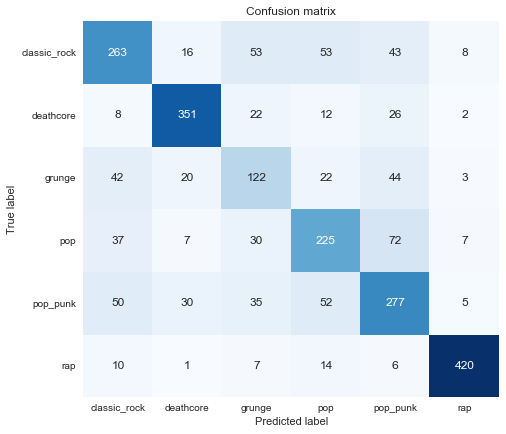

In [173]:
%%time
data_test = count_vectorizer.transform(X_test)
predict(logreg,data_test,y_test)

### Averaging word vectors -  word2vec embedding

Используя готовое векторное представление слов в виде обученных по корпусу GoogleNews Word2Vec, представим каждый текст песни в виде некоторого суммарного вектора слов 

In [25]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim.models import Word2Vec

2017-06-06 09:58:20,361 : WARNING : Slow version of gensim.models.doc2vec is being used
2017-06-06 09:58:20,553 : INFO : 'pattern' package not found; tag filters are not available for English


In [26]:
%%time 
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz",binary=True,limit=500000)
wv.init_sims(replace=True)

2017-06-06 09:58:25,296 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2017-06-06 09:58:51,287 : INFO : loaded (500000, 300) matrix from GoogleNews-vectors-negative300.bin.gz
2017-06-06 09:58:51,294 : INFO : precomputing L2-norms of word weight vectors


Wall time: 32.1 s


In [27]:
len(wv.vocab.keys())

500000

In [28]:
wv.similar_by_word('love',topn=5)

[('loved', 0.6907792091369629),
 ('adore', 0.6816873550415039),
 ('loves', 0.6618633270263672),
 ('passion', 0.6100709438323975),
 ('hate', 0.600395679473877)]

In [55]:
from itertools import islice
list(islice(wv.vocab, 1000, 1020))

['Paul',
 'store',
 'gets',
 'filed',
 'huge',
 'moving',
 'seems',
 'met',
 '####s',
 'thousands',
 'CEO',
 'solutions',
 'score',
 'content',
 'treatment',
 'offered',
 'built',
 'hits',
 'present',
 'Chicago']

Судя по словарю обученной на GoogleNews Word2Vec модели, при пребобработке не используется приведение к нижнему регистру и токенизация, поэтому заново предобработаем датасет

In [43]:
data = pd.read_csv("songs.csv")
data=data[~data['lyrics'].isnull()]

In [44]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            #if word in stopwords.words('english'):
            if word in stopwords:
                continue                    
            tokens.append(word)
    return tokens

Для работы с Word2Vec необходим формат, когда текст представлен в виде преобработанного массива слов, а не строки. Поэтому заново сделаем разбиение на train / test, чтобы работать с нужным форматом переменных

In [45]:
from sklearn.model_selection import train_test_split
X_train_wv, X_test_wv, y_train, y_test = train_test_split(data['lyrics'], data['genre'], test_size=0.33, random_state=7)

In [47]:
X_train_wv[:5]

2436                                       [Instrumental]
4987    [Intro] Hey excuse me  [Verse 1] Hi my name is...
5392    [Verse 1] I am just a new boy A stranger in th...
584     [Intro] So you made it... this far We upstairs...
5670    [Verse 1] I lost ten points just for being in ...
Name: lyrics, dtype: object

In [48]:
%%time
train_tokenized = X_train_wv.apply(lambda x: w2v_tokenize_text(x)).values
test_tokenized  = X_test_wv.apply(lambda x: w2v_tokenize_text(x)).values

Wall time: 23.3 s


In [50]:
train_tokenized[:2]

array([['Instrumental'],
       ['Intro', 'Hey', 'excuse', 'Verse', 'Hi', 'name', 'Bob', 'work', 'job', 'make', 'forty-some', 'dollars', 'day', 'used', 'man', 'hometown', 'Until', 'started', 'lose', 'way', 'It', 'goes', 'back', 'dropped', 'outta', 'school', 'Having', 'fun', 'living', 'life', 'But', 'got', 'problem', 'little', 'white', 'rock', 'See', 'ca', "n't", 'put', 'pipe', 'Bridge', 'And', 'breaking', 'watching', 'world', 'spin', 'round', 'While', 'dreams', 'fall', 'anybody', 'It', 'breaking', 'friends', 'around', 'And', 'dreams', 'fall', 'anybody', 'Hook', 'Can', 'anybody', 'hear', 'Cause', 'ca', "n't", 'seem', 'hear', 'Can', 'anybody', 'see', 'Cause', 'ca', "n't", 'seem', 'see', 'There', "'s", 'got', 'ta', 'heaven', 'somewhere', 'Can', 'save', 'hell', 'Can', 'anybody', 'feel', 'Cause', 'ca', "n't", 'seem', 'feel', 'Losing', 'way', 'Keep', 'losing', 'way', 'Keep', 'losing', 'way', 'Can', 'help', 'find', 'way', 'Verse', 'Now', 'got', 'ta', 'understand', 'family', 'man', 'woulda', '

Поскольку 'общий средний' вектор текста песен формируется из отдельных векторов слов составляющих текст песни, необходимо наличие этого в слова в словаре предобученной  Word2Vec  модели или наличие синонима к этому слову. Возможны ситуации когда слова из текста песни нет в словаре. Такие ситуации необходимо обработать вручную. Найдем слова которых нет  в словаре Word2Vec

In [51]:
def word_averaging(wv, words):    
    mean = []    
    for word in words:
        if isinstance(word, np.ndarray):
            mean=1
        elif word in wv.vocab:
            mean=1          
            
    if not mean:
        print (word)        
def  word_averaging_list(wv, text_list):  
    print('word_averaging_list')
    [word_averaging(wv, review) for review in text_list ]

In [52]:
%%time
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

word_averaging_list
CDLP
word_averaging_list
Wall time: 1.58 s


Заменим cdlp на cd

In [53]:
wv.similar_by_word('CD',topn=5)

[('CDs', 0.7906842231750488),
 ('album', 0.7124601602554321),
 ('cd', 0.6930321455001831),
 ('disc', 0.6868018507957458),
 ('compact_disc', 0.6676390171051025)]

In [54]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)
        # отдельно обработаем слова которых не было в словаре
        elif word.lower()=="cdlp" :
            word="CD"
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        #logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        #return np.zeros(wv.layer1_size,)  
        pass

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])    

In [55]:
%%time
# итоговое векторное представление текста песни (текста, не одного слова)
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

Wall time: 3.79 s


Precision macro:   0.44
Precision micro:   0.51
Recall         :   0.47
F1-measure     :   0.43
Accuracy       :   0.51
Wall time: 1.07 s


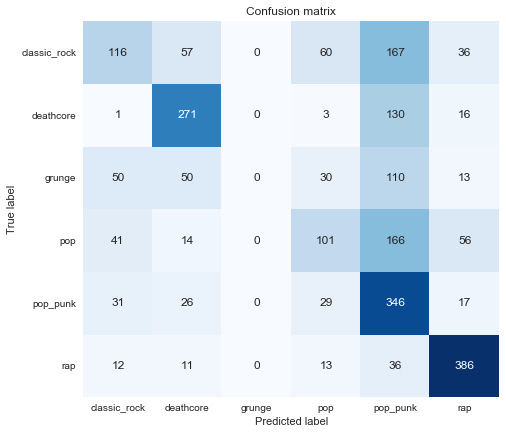

In [56]:
%%time
#Input X must be non-negative
from sklearn.preprocessing import MinMaxScaler

clf = Pipeline([('scaler', MinMaxScaler(feature_range=(0, 1))),
                ('clf', MultinomialNB())])

clf.fit(X_train_word_average, y_train)
predict(clf, X_test_word_average, y_test)

Precision macro:   0.49
Precision micro:   0.52
Recall         :   0.49
F1-measure     :   0.48
Accuracy       :   0.52
Wall time: 1.02 s


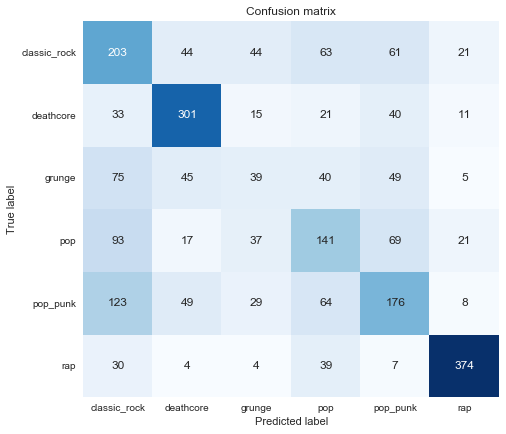

In [57]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train_word_average, y_train)
predict(clf, X_test_word_average, y_test)

Precision macro:   0.64
Precision micro:   0.66
Recall         :   0.64
F1-measure     :   0.63
Accuracy       :   0.66
Wall time: 6.63 s


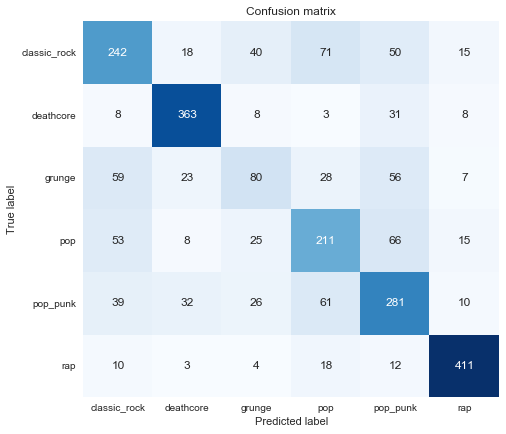

In [58]:
%%time
clf = LogisticRegression(n_jobs=-1, C=1e5)
clf.fit(X_train_word_average, y_train)
predict(clf, X_test_word_average, y_test)

### Doc2Vec

In [59]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [66]:
data = pd.read_csv("songs.csv")
data=data[~data['lyrics'].isnull()]
train_data, test_data = train_test_split(data, test_size=0.33, random_state=7)

In [64]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [70]:
%%time
train_tagged = train_data.apply(
    lambda x: TaggedDocument(words=tokenize_text(x['lyrics']), tags=[x.genre]), axis=1)
test_tagged = test_data.apply(
    lambda x: TaggedDocument(words=tokenize_text(x['lyrics']), tags=[x.genre]), axis=1)

In [73]:
train_tagged.values[1]

TaggedDocument(words=['intro', 'hey', 'excuse', 'me', 'verse', 'hi', 'my', 'name', 'is', 'bob', 'and', 'work', 'at', 'my', 'job', 'make', 'forty-some', 'dollars', 'day', 'used', 'to', 'be', 'the', 'man', 'in', 'my', 'hometown', 'until', 'started', 'to', 'lose', 'my', 'way', 'it', 'all', 'goes', 'back', 'to', 'when', 'dropped', 'outta', 'school', 'having', 'fun', 'was', 'living', 'the', 'life', 'but', 'now', 'got', 'problem', 'with', 'that', 'little', 'white', 'rock', 'see', 'ca', "n't", 'put', 'down', 'the', 'pipe', 'bridge', 'and', 'it', 'is', 'breaking', 'me', 'down', 'watching', 'the', 'world', 'spin', 'round', 'while', 'my', 'dreams', 'fall', 'down', 'is', 'anybody', 'out', 'there', 'it', 'is', 'breaking', 'me', 'down', 'no', 'more', 'friends', 'around', 'and', 'my', 'dreams', 'fall', 'down', 'is', 'anybody', 'out', 'there', 'hook', 'can', 'anybody', 'out', 'there', 'hear', 'me', 'cause', 'ca', "n't", 'seem', 'to', 'hear', 'myself', 'can', 'anybody', 'out', 'there', 'see', 'me', 'c

In [76]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=4, size=5, iter=25, dm=1)

2017-06-06 13:24:38,538 : WARNING : Slow version of gensim.models.word2vec is being used
2017-06-06 13:24:38,545 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-06-06 13:24:38,552 : INFO : collecting all words and their counts
2017-06-06 13:24:38,560 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-06-06 13:24:38,928 : INFO : collected 36215 word types and 6 unique tags from a corpus of 4860 examples and 1472462 words
2017-06-06 13:24:38,936 : INFO : Loading a fresh vocabulary
2017-06-06 13:24:38,993 : INFO : min_count=5 retains 10447 unique words (28% of original 36215, drops 25768)
2017-06-06 13:24:39,001 : INFO : min_count=5 leaves 1430777 word corpus (97% of original 1472462, drops 41685)
2017-06-06 13:24:39,060 : INFO : deleting the raw counts dictionary of 36215 items
2017-06-06 13:24:39,068 : INFO : sample=0.001 downsamples 65 most-common words
2017-06-06 13:24:39,076 : INFO : downsampling leaves estimat

Wall time: 2h 42min 17s


In [77]:
import pickle
with open('doc2vec_model.pkl', 'wb') as fp:
    pickle.dump(doc2vec_model, fp)

In [79]:
%%time
train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

Wall time: 1h 23min 46s


In [80]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

Wall time: 39min 50s


In [94]:
train_regressors[:5]

(array([-0.06447323,  0.05643792, -0.11161116,  0.0134319 , -0.03983296], dtype=float32),
 array([-0.33340761,  1.3770864 , -3.23769593, -1.21214807,  0.22863427], dtype=float32),
 array([-0.19641812,  0.09960784, -1.96480584, -0.39051268,  0.34961194], dtype=float32),
 array([ 1.27664196,  0.45458266, -2.07563901, -1.4575212 , -0.26275033], dtype=float32),
 array([-0.69556201,  0.89948982, -2.08059096, -1.02691221,  0.56486726], dtype=float32))

Какие слова ближе всего к каждому жанру

In [81]:
doc2vec_model.most_similar([doc2vec_model.docvecs['pop']])

2017-06-06 18:37:01,643 : INFO : precomputing L2-norms of word weight vectors


[('chorus', 0.9976367950439453),
 ('sing', 0.9973166584968567),
 ('post-chorus', 0.9962420463562012),
 ("'re", 0.9914135932922363),
 ('harry', 0.9909666180610657),
 ('whoa-oh', 0.9903594255447388),
 ('disappears', 0.9873340725898743),
 ('you’re', 0.9849534034729004),
 ('beautiful', 0.9831712245941162),
 ('detox', 0.9819667339324951)]

In [84]:
doc2vec_model.most_similar([doc2vec_model.docvecs['rap']])

[('mo', 0.9952982664108276),
 ('nigga', 0.9929370284080505),
 ("y'all", 0.9926278591156006),
 ('shit', 0.9894787669181824),
 ('hustle', 0.9894396662712097),
 ('punk', 0.9885159134864807),
 ('motherfucking', 0.9863172769546509),
 ('gettin', 0.984445333480835),
 ('call', 0.9801669716835022),
 ('bitch', 0.9799970984458923)]

In [85]:
doc2vec_model.most_similar([doc2vec_model.docvecs['classic_rock']])

[('night', 0.9886524677276611),
 ('moves', 0.9877834320068359),
 ('waiting', 0.9867610931396484),
 ('detox', 0.9860248565673828),
 ('sad', 0.9835730195045471),
 ("'re", 0.983157753944397),
 ('lonely', 0.9799982905387878),
 ('beautiful', 0.976382851600647),
 ('whoa-oh', 0.97551029920578),
 ('comes', 0.9754945635795593)]

Precision macro:   0.54
Precision micro:   0.60
Recall         :   0.56
F1-measure     :   0.53
Accuracy       :   0.60


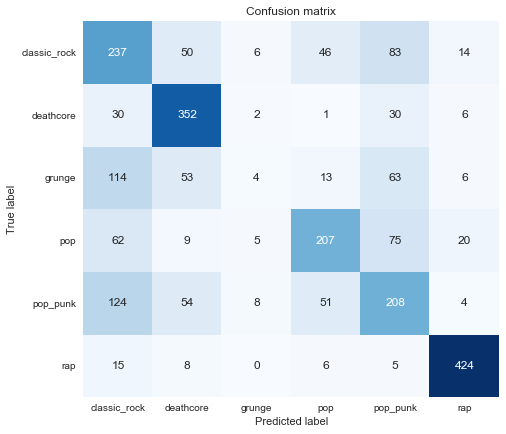

In [90]:
clf = LogisticRegression(n_jobs=1, C=1e5)
clf = logreg.fit(train_regressors, train_targets)
#evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))
predict(clf, test_regressors, test_targets)

Выберем три лучшие модели для которых будем конструировать новые признаки из словаря тональностей  NRCWord-Emotion Association Lexicon

### Задание 3
В словаре NRCWord-Emotion Association Lexicon насчитывается более чем 14 тысяч слов, размеченных в соответствии с эмоцией, которая свойственна сущности, описываемой данным словом. Всего эмоций 8: гнев (anger), предчувствие (anticipation), отвращение (disgust), страх (fear), радость (joy), грусть (sadness), удивление (surprise), доверие (trust), а также две глобальные (положительная (positive) и негативная (negative)). К векторному представлению текста песни добавьте два новых признака: долю позитивных слов и долю негативных слов в этом тексте

In [34]:
data = pd.read_pickle('data_PorterStemmer.pkl')
data['lyrics'][:2]

0    [part, produc, phaze, vers, like, dirt, dig, o...
1    [teller, kill, eminem, hurri, fuck, shoot, tel...
Name: lyrics, dtype: object

In [35]:
nrc_dict = pd.read_csv("NRC-english.csv",\
          names=['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','positive','negative'])
nrc_dict.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,positive,negative
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,1,0,0,0,1,0,1,0,0
abandoned,0,1,1,0,0,1,0,1,0,0
abandonment,0,1,1,0,0,1,0,1,1,0


In [36]:
text=data['lyrics'] #[:100]

def new_features(texts,type_emotion):
    part_emotion, i = [],1
    for text in texts: 
        if i%1000==0 : print(i)
        i+=1
        emotion=[1 for text_ in text  if text_ in list(nrc_dict.index) and nrc_dict[type_emotion].loc[text_]==1 ]
        part_emotion_=len(emotion)*1./len(text)
        part_emotion.append(part_emotion_)
    return part_emotion

In [37]:
%%time
positive = new_features(text,'positive')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 35s


In [38]:
%%time
negative = new_features(text,'negative')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 31s


In [39]:
len(negative)

7255

Посчитаем также долю слов отражающих каждую из 8 категорий эмоций присутствующих в словаре NRCWord-Emotion Association Lexicon

In [37]:
%%time
anger = new_features(text,'anger')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 24s


In [38]:
%%time
anticipation = new_features(text,'anticipation')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 39s


In [39]:
%%time
disgust = new_features(text,'disgust')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 54s


In [40]:
%%time
fear = new_features(text,'fear')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 16s


In [41]:
%%time
joy = new_features(text,'joy')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 21s


In [42]:
%%time
sadness = new_features(text,'sadness')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 51s


In [43]:
%%time
surprise = new_features(text,'surprise')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 33s


In [44]:
%%time
trust = new_features(text,'trust')

1000
2000
3000
4000
5000
6000
7000
Wall time: 11min 34s


**TF-IDF  LogisticRegression**

In [45]:
# для TfidfVectorizer и CountVectorizer нужно снова join-нить
data['lyrics']=data['lyrics'].apply(lambda x: ' '.join(x))
data=data[['lyrics','genre']]

Precision macro:   0.68
Precision micro:   0.70
Recall         :   0.68
F1-measure     :   0.68
Accuracy       :   0.70
Wall time: 4 s


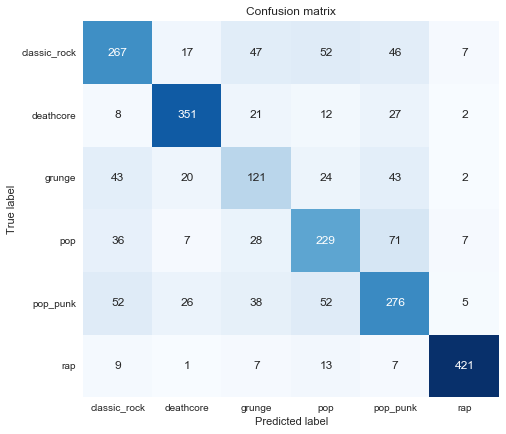

In [51]:
%%time
count_vectorizer = TfidfVectorizer(min_df=2,preprocessor=None)
data_transform = count_vectorizer.fit_transform(data['lyrics'])

# чтобы добавить в sparse matrix столбец нужно привести его к формату лист листов - [[],[],[]]
positive_, negative_ = [],[]
for p,n in zip(positive, negative):
    positive_.append([p])
    negative_.append([n])

#добавим новые признаки в  sparse matrix data_transform для этого преобразуем в формат  coo_matrix
#в начальный формат data_transform Compressed Sparse Row нельзя дописать
from scipy.sparse import coo_matrix, vstack, hstack
data_transform_ = hstack(( coo_matrix(data_transform),positive_, negative_ ))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_transform_, data['genre'], test_size=0.33, random_state=7)

logreg = LogisticRegression(n_jobs=-1, C=1e5)
logreg = logreg.fit(X_train, y_train)

predict(logreg, X_test, y_test)

**Bag of words  LogisticRegression**

Precision macro:   0.65
Precision micro:   0.67
Recall         :   0.64
F1-measure     :   0.65
Accuracy       :   0.67
Wall time: 9.53 s


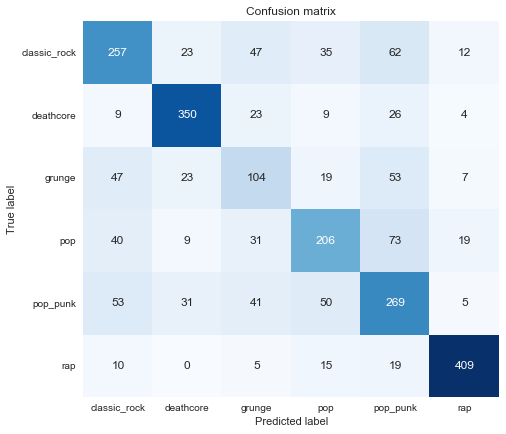

In [52]:
%%time
count_vectorizer = CountVectorizer(analyzer="word",preprocessor=None, max_features=3000) 
data_transform = count_vectorizer.fit_transform(data['lyrics'])

#добавим новые признаки в  sparse matrix data_transform для этого преобразуем в формат  coo_matrix
#в начальный формат data_transform Compressed Sparse Row нельзя дописать
from scipy.sparse import coo_matrix, vstack, hstack
data_transform_ = hstack(( coo_matrix(data_transform),positive_, negative_ ))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_transform_, data['genre'], test_size=0.33, random_state=7)

logreg = LogisticRegression(n_jobs=-1, C=1e5)
logreg = logreg.fit(X_train, y_train)

predict(logreg, X_test, y_test)

Добавление двух новых признаков доли позитивных слов и доли негативных слов в тексте дает прирост метрик качества (Accuracy) на 0.01

### Задание 4
Предложите и реализуйте дополнительные признаки для классификации текстов песен по жанру.

Сформируем дополнительные признаки которые будут отражать эмоции в текстах песен. Посчитаем долю слов отражающих каждую из 8 категорий эмоций присутствующих в словаре NRCWord-Emotion Association Lexicon

**TF-IDF LogisticRegression**

Precision macro:   0.67
Precision micro:   0.69
Recall         :   0.67
F1-measure     :   0.67
Accuracy       :   0.69
Wall time: 3.84 s


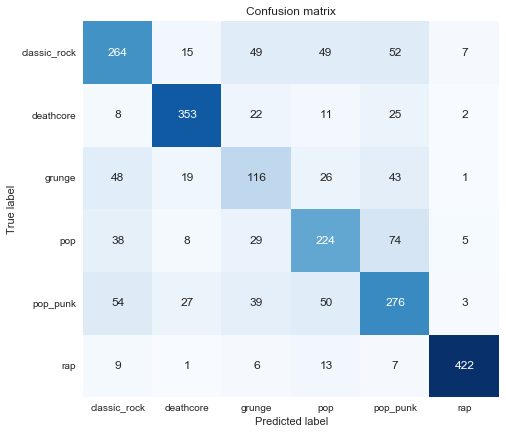

In [54]:
%%time
count_vectorizer = TfidfVectorizer(min_df=2,preprocessor=None)
data_transform = count_vectorizer.fit_transform(data['lyrics'])

# чтобы добавить в sparse matrix столбец нужно привести его к формату лист листов - [[],[],[]]
positive_, negative_ = [],[]
anger_, anticipation_, disgust_, fear_, joy_, sadness_, surprise_, trust_ = [],[],[],[],[],[],[],[],

for p,n,a,a2,d,f,j,s,s2,t in zip(positive, negative, anger, anticipation, disgust, fear, joy, sadness, surprise, trust ):
    positive_.append([p])
    negative_.append([n])
    anger_.append([a])   
    anticipation_.append([a2])
    disgust_.append([d])
    fear_.append([f])
    joy_.append([j])
    sadness_.append([s])
    surprise_.append([s2])
    trust_.append([t])
    
#добавим новые признаки в  sparse matrix data_transform для этого преобразуем в формат  coo_matrix
#в начальный формат data_transform Compressed Sparse Row нельзя дописать
from scipy.sparse import coo_matrix, vstack, hstack
data_transform_ = hstack(( coo_matrix(data_transform),\
                          positive_, negative_,anger_,anticipation_, disgust_, fear_, joy_, sadness_, surprise_, trust_ ))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_transform_, data['genre'], test_size=0.33, random_state=7)

logreg = LogisticRegression(n_jobs=-1, C=1e5)
logreg = logreg.fit(X_train, y_train)

predict(logreg, X_test, y_test)

**Bag of words LogisticRegression**

Precision macro:   0.65
Precision micro:   0.67
Recall         :   0.65
F1-measure     :   0.65
Accuracy       :   0.67
Wall time: 10 s


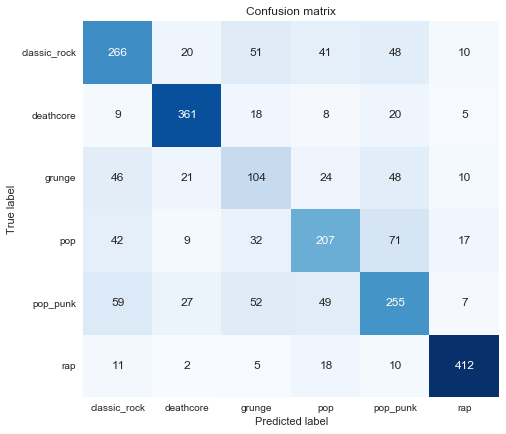

In [56]:
%%time
count_vectorizer = CountVectorizer(analyzer="word",preprocessor=None, max_features=3000) 
data_transform = count_vectorizer.fit_transform(data['lyrics'])

# чтобы добавить в sparse matrix столбец нужно привести его к формату лист листов - [[],[],[]]
positive_, negative_ = [],[]
anger_, anticipation_, disgust_, fear_, joy_, sadness_, surprise_, trust_ = [],[],[],[],[],[],[],[],

for p,n,a,a2,d,f,j,s,s2,t in zip(positive, negative, anger, anticipation, disgust, fear, joy, sadness, surprise, trust ):
    positive_.append([p])
    negative_.append([n])
    anger_.append([a])   
    anticipation_.append([a2])
    disgust_.append([d])
    fear_.append([f])
    joy_.append([j])
    sadness_.append([s])
    surprise_.append([s2])
    trust_.append([t])
    
#добавим новые признаки в  sparse matrix data_transform для этого преобразуем в формат  coo_matrix
#в начальный формат data_transform Compressed Sparse Row нельзя дописать
from scipy.sparse import coo_matrix, vstack, hstack
data_transform_ = hstack(( coo_matrix(data_transform),\
                          positive_, negative_,anger_,anticipation_, disgust_, fear_, joy_, sadness_, surprise_, trust_ ))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_transform_, data['genre'], test_size=0.33, random_state=7)

logreg = LogisticRegression(n_jobs=-1, C=1e5)
logreg = logreg.fit(X_train, y_train)

predict(logreg, X_test, y_test)

In [64]:
df_NRCWord = pd.DataFrame(list(zip(positive, negative, anger, anticipation, disgust, fear, joy, sadness, surprise, trust )),\
        columns=['positive', 'negative', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'])

In [68]:
df_NRCWord.describe().T

,count,mean,std,min,25%,50%,75%,max
positive,7255.0,0.027552,0.030978,0.0,0.008264,0.019900,0.037037,0.500000
negative,7255.0,0.044246,0.040040,0.0,0.018361,0.036232,0.059259,0.545455
anger,7255.0,0.073601,0.054281,0.0,0.038462,0.063492,0.095603,0.555556
anticipation,7255.0,0.084210,0.060356,0.0,0.041124,0.075000,0.114639,1.000000
disgust,7255.0,0.038633,0.038526,0.0,0.010667,0.029801,0.056051,0.518519
fear,7255.0,0.049612,0.043287,0.0,0.022195,0.040486,0.066038,0.500000
joy,7255.0,0.029387,0.033797,0.0,0.005525,0.020942,0.042064,0.518519
sadness,7255.0,0.046219,0.044870,0.0,0.014354,0.035422,0.064516,0.500000
surprise,7255.0,0.043709,0.044614,0.0,0.015385,0.032258,0.057629,0.500000
trust,7255.0,0.045215,0.042770,0.0,0.016393,0.034826,0.061224,0.518519


In [79]:
#plt.figure(figsize(17,5));
#df_NRCWord[:100].plot(kind='line');

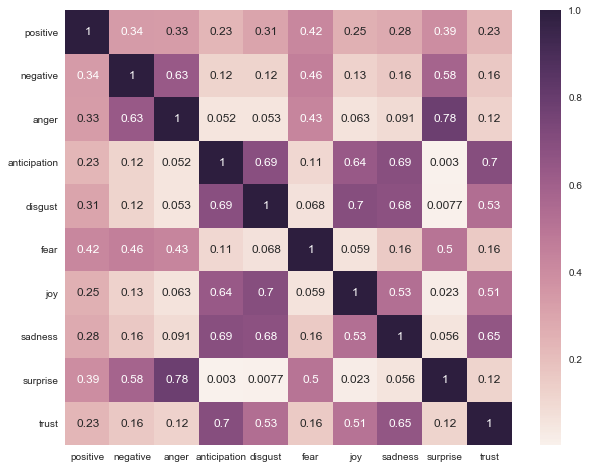

In [70]:
from scipy.stats import spearmanr
corr = spearmanr(df_NRCWord).correlation
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, xticklabels = list(df_NRCWord), yticklabels = list(df_NRCWord));

Добавление новых дополнительных признаков отражающих эмоции в текстах песен не повышает качество классификации. Возможно стоит рассмотреть их попарные пересечения как новые признаки

** Итоговые значения Accuracy классификаторов**